In [1]:
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/final/GP_models')
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/final')
import helper
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import helper
import numpy as np
import seaborn as sns

In [2]:
def detected_samples(path='/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/beethoven.wav', sample_length=2000, offset=500, show=False, delta=0.05, num_samples=None, normalise=True):
    """
    Returns an array of numpy arrays for each detected onset note
    """
    sample_rate, data = wav.read(path)
    data = data.astype(np.float64) 
    if num_samples is not None:
        data = data[:num_samples]
    onset_times = librosa.onset.onset_detect(
        y=data, post_avg=5, wait=1,  sr=sample_rate, units='time', delta=delta)  # delta=0.15, wait=5, pre_avg=0, post_avg=5, pre_max=5, post_max=10,
    onset_numbers = onset_times * sample_rate

    sample_data = []
    for i in range(len(onset_numbers)):
        sample = data[int(onset_numbers[i]+offset):int(onset_numbers[i] + offset + sample_length)]
        if normalise is True:
            sample = helper.power_normalise(sample)/20
        sample_data.append(sample)
    if show is True:
        print("here")
        audio_duration = len(data)/sample_rate
        time_samples = np.linspace(0, audio_duration, len(data))
        helper.plot_audio(time_samples, data)
        for time in onset_times:
            plt.vlines(time + offset/sample_rate, ymin=-
                       25000, ymax=25000, colors='blue', zorder=2,linewidths=1)
            # plt.vlines(time + offset/sample_rate + sample_length /
            #            sample_rate, ymin=-25000, ymax=25000, colors='pink', zorder=2, linewidths=1)
    return sample_data, sample_rate, onset_times+500/44100


here


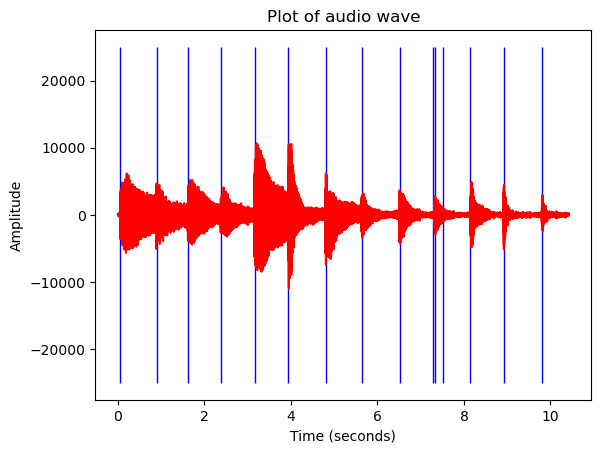

In [14]:
wav_file = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/final/experiments/experiment_wav_files/circle_5ths.wav'
sample_rate, data = wav.read(wav_file)
# print(type(data))
sample_data, sample_rate, onset_times  = detected_samples(wav_file, sample_length=700, offset=0, show=True, delta=0.05,num_samples=1000000,normalise=False)
time_samples = np.linspace(
    0, len(sample_data[0])/sample_rate, len(sample_data[0]))

In [4]:
indices_to_delete = [9, 11]  # List of indices to delete
sample_data = [element for index, element in enumerate(
    sample_data) if index not in indices_to_delete]
print(len(sample_data))

13


In [5]:
M=9
T=0.465
v=2.37
notes = ["A0", "E1", "B1", "F#2", "C#3", "G#3", "D#4", "A#4", "F5", "C6", "G6", "D7", "A7"]
sigma=1/500000

In [7]:
# Frequency calculation for circles of fifths starting from 27.5 Hz
f_base = 27.5
frequencies = [f_base * (2 ** (7/12)) ** i for i in range(len(sample_data))]

# Prepare to store the results
sigma_values = np.logspace(-8, 0, 50)  # M from 1 to 15
results = np.zeros((len(sigma_values), len(sample_data)))

# Compute LMLs for each combination of M and sample_data index
for i, sigma in enumerate(sigma_values):
    for j in range(len(sample_data)):
        results[i, j] = -helper.stable_nlml(time_samples, sample_data[j], M=M, sigma_f=sigma, f=[frequencies[j]], T=T, v=v)


In [8]:
print(len(frequencies))
print(frequencies)

13
[27.5, 41.20344461410874, 61.735412657015516, 92.49860567790861, 138.59131548843604, 207.65234878997256, 311.1269837220809, 466.1637615180899, 698.4564628660078, 1046.5022612023947, 1567.9817439269973, 2349.318143339261, 3520.000000000001]


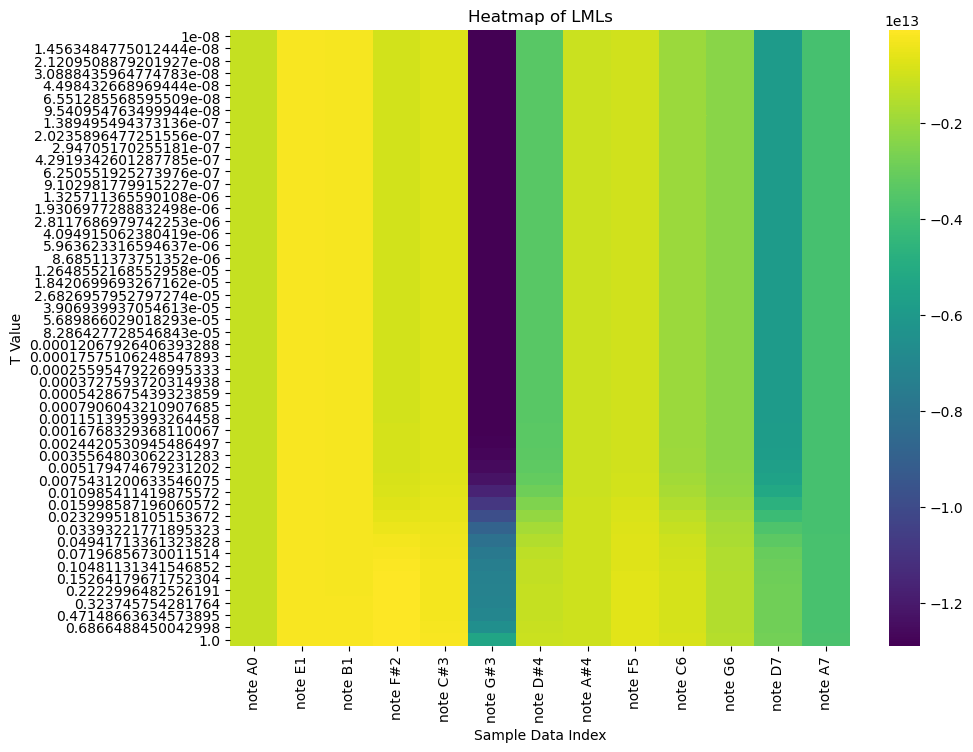

In [9]:


plt.figure(figsize=(10, 8))
sns.heatmap(results, annot=False, cmap="viridis", xticklabels=[f"note {notes[i]}" for i in range(len(sample_data))], yticklabels=sigma_values)
plt.title("Heatmap of LMLs")
plt.xlabel("Sample Data Index")
plt.ylabel("T Value")
plt.show()

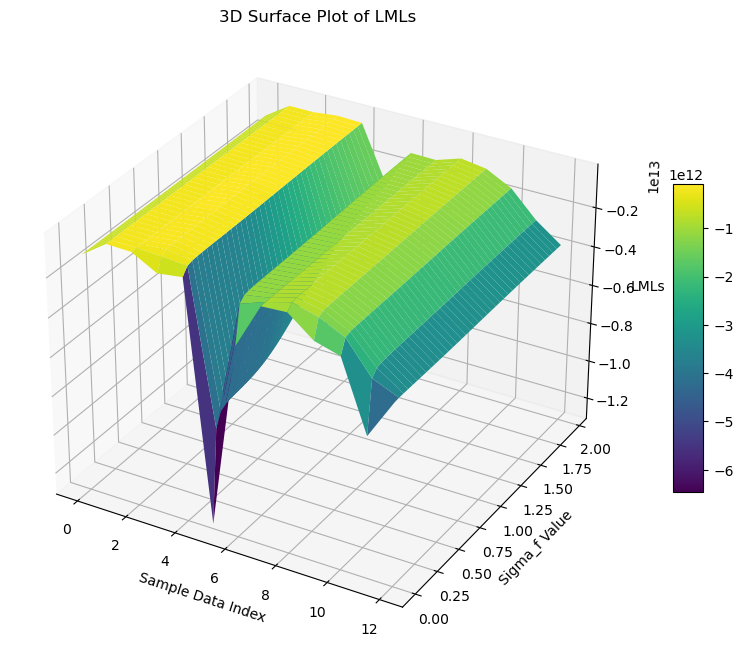

In [14]:

sample_data_indices = np.arange(len(sample_data))  # Indices of your sample data

# Create meshgrid
X, Y = np.meshgrid(sample_data_indices, sigma_values)

# Set up a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, results, cmap='viridis')

# Labels and title
ax.set_xlabel('Sample Data Index')
ax.set_ylabel('Sigma_f Value')
ax.set_zlabel('LMLs')
ax.set_title('3D Surface Plot of LMLs')

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()

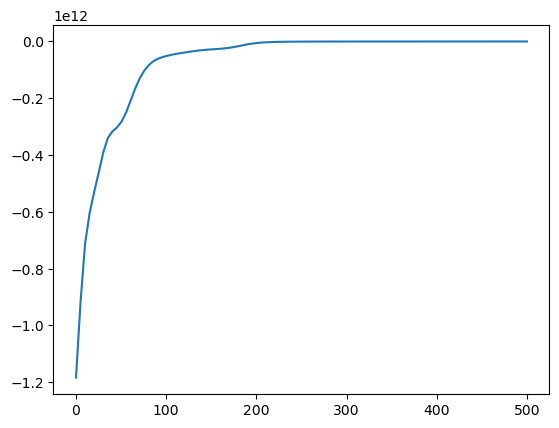

In [11]:
# Now looking at one frequency:
n = 0
data = sample_data[n]
LMLs = []
sigmas = np.linspace(0.0005, 500, 100)
for sigma in sigmas:
    LMLs.append(-helper.stable_nlml(time_samples,data, M=M, sigma_f=sigma, f=[frequencies[n]], T=T, v=v))

plt.plot( sigmas,LMLs)
plt.show()

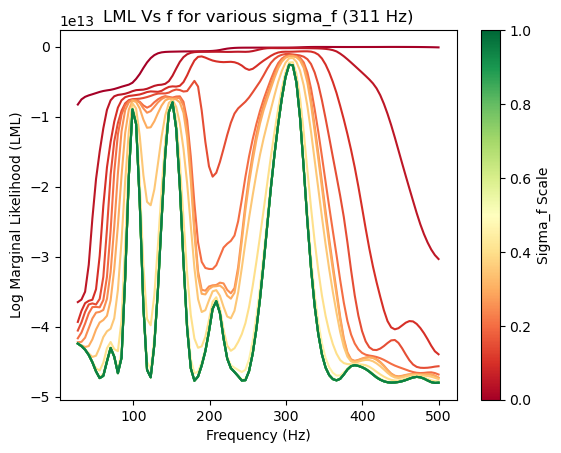

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

fs = np.linspace(27, 500, 100)
n = 6  # Presumed to be the index for 311 Hz in sample_data
data = sample_data[n]
sigma_f_values = np.logspace(np.log10(1/5000000), np.log10(50), 20)  # Generates 20 values from 1/500000 to 50 on a logarithmic scale

# Define colormap
cmap = get_cmap('RdYlGn')  # 'RdYlGn_r' is a red to green colormap, reversed to go from green to red

# Plot each line with color mapped to the sigma_f value
for i, sigma_f in enumerate(reversed(sigma_f_values)):
    LMLs = []
    for f in fs:
        LML = -helper.stable_nlml(time_samples, data, M=9, sigma_f=sigma_f,  f=[f], T=T, v=v)
        LMLs.append(LML)
    color = cmap(i / len(sigma_f_values))  # Normalize index for color mapping
    plt.plot(fs, LMLs, color=color, label=f'sigma_f = {sigma_f:.5f}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Marginal Likelihood (LML)')
plt.title('LML vs. Frequency for Various sigma_f (311 Hz)')
# plt.legend(title='Sigma_f values', loc='upper right')
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), label='Sigma_f Scale')
plt.show()


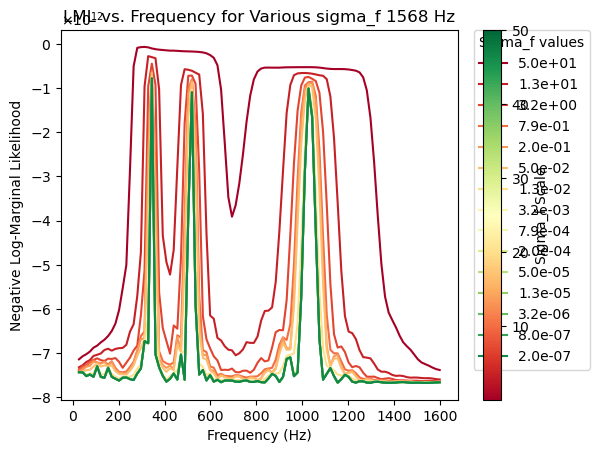

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import ScalarFormatter

fs = np.linspace(27, 1600, 100)
n =  10 # Presumed to be the index for 1568 Hz in sample_data
data = sample_data[n]
sigma_f_values = np.logspace(np.log10(1/5000000), np.log10(50), 15)  # Generates 15 values from 1/500000 to 50 on a logarithmic scale

# Define colormap
cmap = get_cmap('RdYlGn')  # 'RdYlGn_r' is a red to green colormap, reversed to go from green to red

fig, ax = plt.subplots()

# Plot each line with color mapped to the sigma_f value
for i, sigma_f in enumerate(reversed(sigma_f_values)):
    LMLs = []
    for f in fs:
        LML = -helper.stable_nlml(time_samples, data, M=9, sigma_f=sigma_f, f=[f], T=T, v=v)
        LMLs.append(LML)
    color = cmap(i / len(sigma_f_values))  # Normalize index for color mapping
    ax.plot(fs, LMLs, color=color, label=f'{sigma_f:.1e}')  # Use scientific notation in the label

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Negative Log-Marginal Likelihood')
ax.set_title('LML vs. Frequency for Various sigma_f 1568 Hz')

# Create legend outside the plot area
leg = ax.legend(title='Sigma_f values', loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0)
leg._legend_box.align = "left"

# Format legend text to use scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1,1))
plt.gca().yaxis.set_major_formatter(formatter)

# Add colorbar and adjust its position
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(sigma_f_values), vmax=max(sigma_f_values)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Sigma_f Scale')
cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Ensure the colorbar ticks are in scientific notation

plt.show()
